In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from scipy.stats import mode
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

## Random Forest

python(16187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameters (mean val score): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Mean Validation macro F1-score: 0.6871

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.6872    0.8536    0.7614      1742
           1     0.8126    0.5174    0.6322      1668
           2     0.9307    0.9696    0.9498      4408

    accuracy                         0.8473      7818
   macro avg     0.8102    0.7802    0.7811      7818
weighted avg     0.8513    0.8473    0.8401      7818



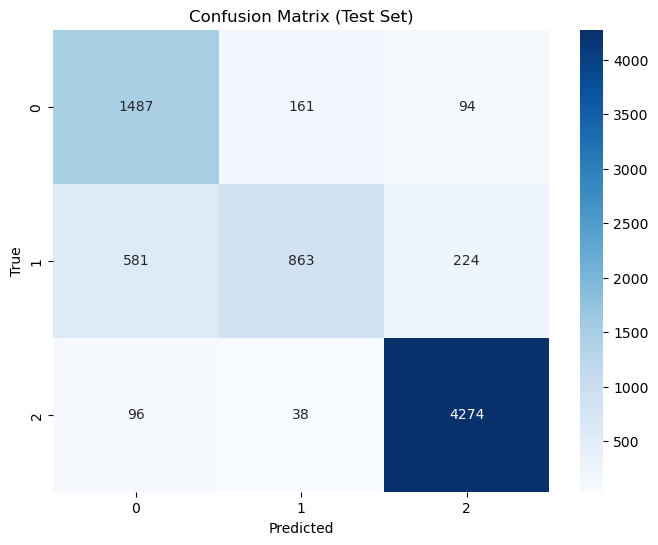

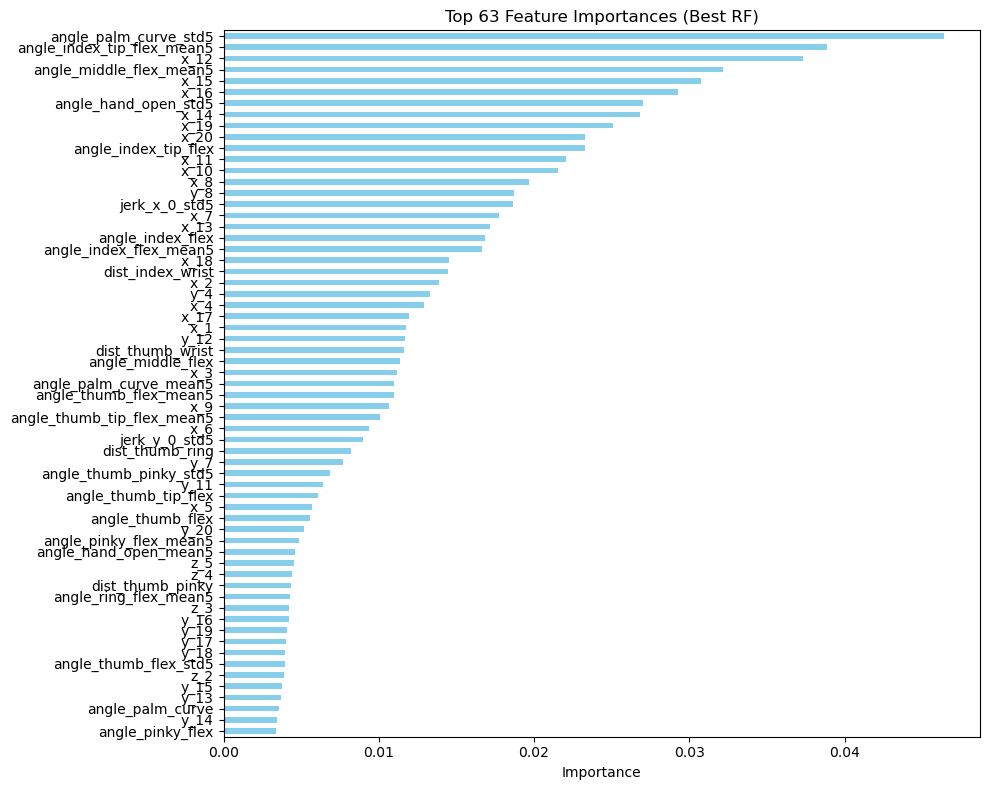

In [197]:
features = all_feature_cols.copy()
target = 'behavior_encoded'
group = 'person_id'

df_rf = df[df[target].isin([0, 1, 2])].copy()
X_rf, y_rf, groups_rf = df_rf[features], df_rf[target], df_rf[group]

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

is_train = groups_rf.isin(train_users)
is_test = groups_rf.isin(test_users)

X_train, y_train = X_rf[is_train], y_rf[is_train]
X_test, y_test = X_rf[is_test], y_rf[is_test]
groups_train = groups_rf[is_train]

param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2']
}

best_score = -np.inf
best_model = None
best_params = None

gkf = GroupKFold(n_splits=6)

for params in ParameterGrid(param_grid):
    fold_scores = []
    
    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf = RandomForestClassifier(
            **params,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_tr, y_tr)
        y_val_pred = rf.predict(X_val)
        score = f1_score(y_val, y_val_pred, average='macro')
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)

    if mean_score > best_score:
        best_score = mean_score
        best_model = rf
        best_params = params

print("Best parameters (mean val score):", best_params)
print("Mean Validation macro F1-score: {:.4f}".format(mean_score))

y_test_pred = best_model.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(63).sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title("Top 63 Feature Importances (Best RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [6]:
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

Train class distribution:
 behavior_encoded
2    0.540591
1    0.332640
0    0.126769
Name: proportion, dtype: float64
Test class distribution:
 behavior_encoded
2    0.524641
0    0.279554
1    0.195805
Name: proportion, dtype: float64


In [146]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from scipy.stats import mode
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

## LSTM


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 1 - Accuracy: 0.8976, Macro F1: 0.8553, F1 Class 0: 0.8433, F1 Class 1: 0.7568, F1 Class 2: 0.9660

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 2 - Accuracy: 0.8867, Macro F1: 0.8396, F1 Class 0: 0.8168, F1 Class 1: 0.7356, F1 Class 2: 0.9663

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 3 - Accuracy: 0.8983, Macro F1: 0.8555, F1 Class 0: 0.8552, F1 Class 1: 0.7461, F1 Class 2: 0.9652

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Run 4 - Accuracy: 0.9002, Macro F1: 0.8578, F1 Class 0: 0.8468, F1 Class 1: 0.7564, F1 Class 2: 0.9701

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Run 5 - Accuracy: 0.8970, Macro F1: 0.8558, F1 Class 0: 0.8295, F1 Class 1: 0.7687, F1 Class 2: 0.9690


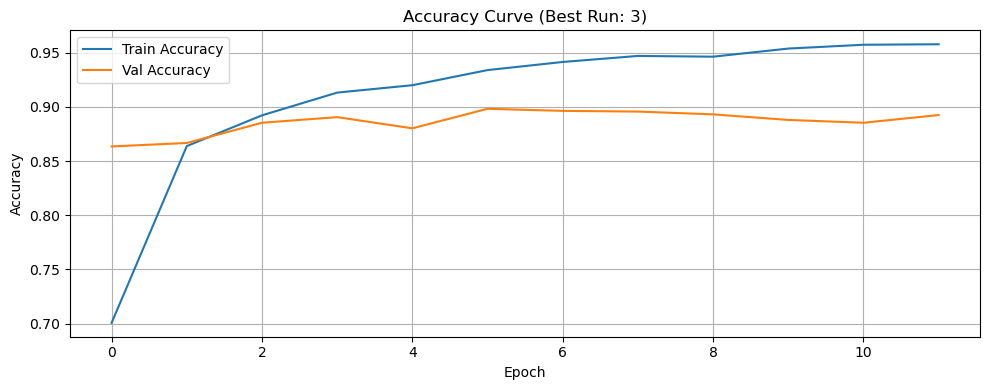

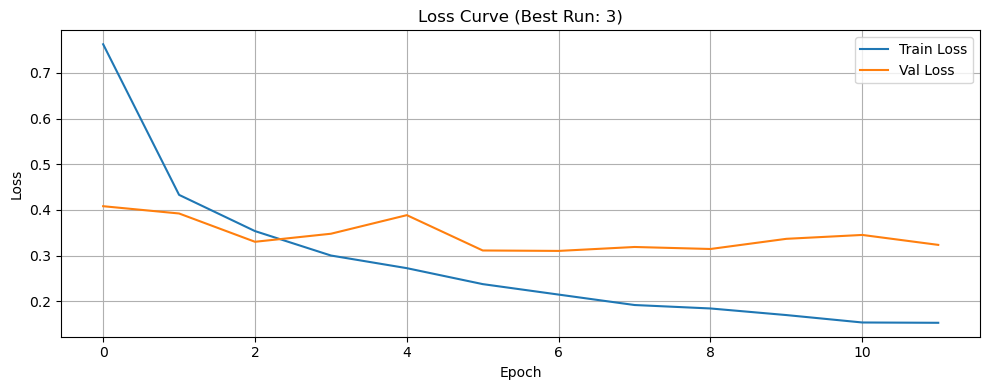


== Confusion Matrix of Best Run (Run 3) ==



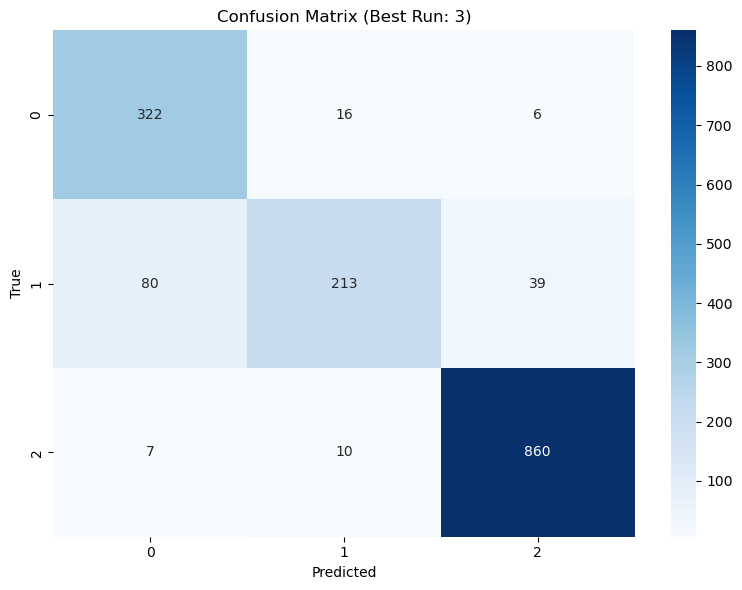

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.897618  0.855336    0.843273    0.756757    0.965979
1     0.886671  0.839582    0.816783    0.735632    0.966330
2     0.898261  0.855504    0.855246    0.746060    0.965208
3     0.900193  0.857768    0.846774    0.756388    0.970141
4     0.896974  0.855767    0.829545    0.768740    0.969014
Mean  0.895943  0.852791    0.838324    0.752715    0.967334
Std   0.004760  0.006663    0.013589    0.011160    0.001901

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.962669,0.889247,0.126061,0.394303
1,0.965846,0.872505,0.112946,0.444308
2,0.957790,0.892466,0.152857,0.323380
3,0.958470,0.878300,0.140657,0.376263
4,0.963463,0.888603,0.123854,0.373529
Mean,0.961648,0.884224,0.131275,0.382356
Std,0.003064,0.007547,0.013943,0.038920


In [237]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [238]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.795865  0.886628  0.838324   344.000000  0.011872  0.039217   
1             0.849791  0.677108  0.752715   332.000000  0.035554  0.030524   
2             0.952711  0.982440  0.967334   877.000000  0.005539  0.002862   
accuracy      0.895943  0.895943  0.895943     0.895943  0.005322  0.005322   
macro avg     0.866122  0.848725  0.852791  1553.000000  0.010901  0.007992   
weighted avg  0.895966  0.895943  0.892877  1553.000000  0.007085  0.005322   

                                  
              f1-score   support  
0             0.015193  0.000000  
1             0.012477  0.000000  
2             0.002125  0.000000  
accuracy      0.005322  0.005322  
macro avg     0.007449  0.000000  
weighted avg  0.005182  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 1 - Accuracy: 0.9041, Macro F1: 0.8622, F1 Class 0: 0.8399, F1 Class 1: 0.7695, F1 Class 2: 0.9771

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2 - Accuracy: 0.8835, Macro F1: 0.8346, F1 Class 0: 0.8471, F1 Class 1: 0.7000, F1 Class 2: 0.9568

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3 - Accuracy: 0.9073, Macro F1: 0.8695, F1 Class 0: 0.8539, F1 Class 1: 0.7821, F1 Class 2: 0.9724

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 4 - Accuracy: 0.8944, Macro F1: 0.8499, F1 Class 0: 0.8408, F1 Class 1: 0.7432, F1 Class 2: 0.9659

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 5 - Accuracy: 0.8950, Macro F1: 0.8474, F1 Class 0: 0.8336, F1 Class 1: 0.7358, F1 Class 2: 0.9730


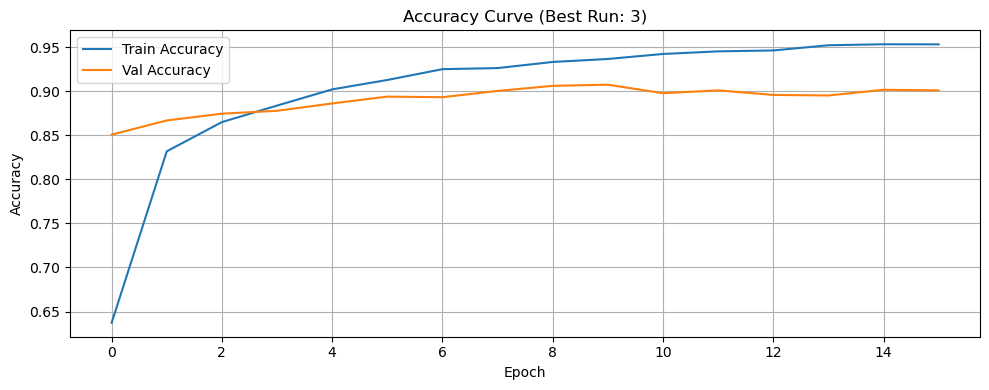

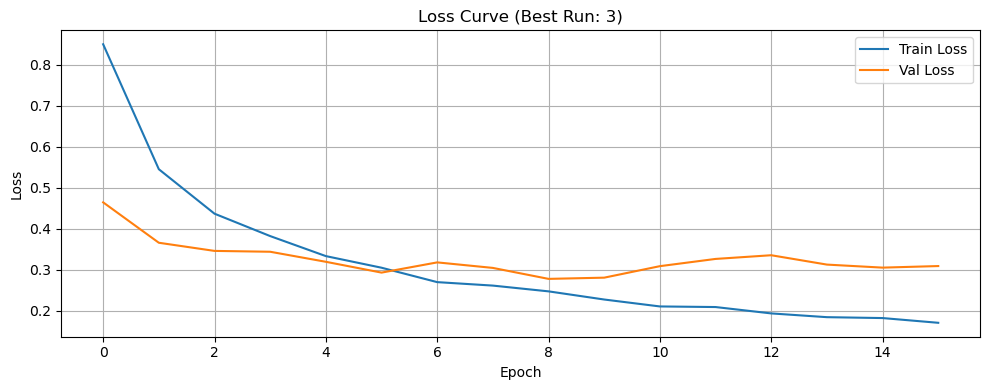


== Confusion Matrix of Best Run (Run 3) ==



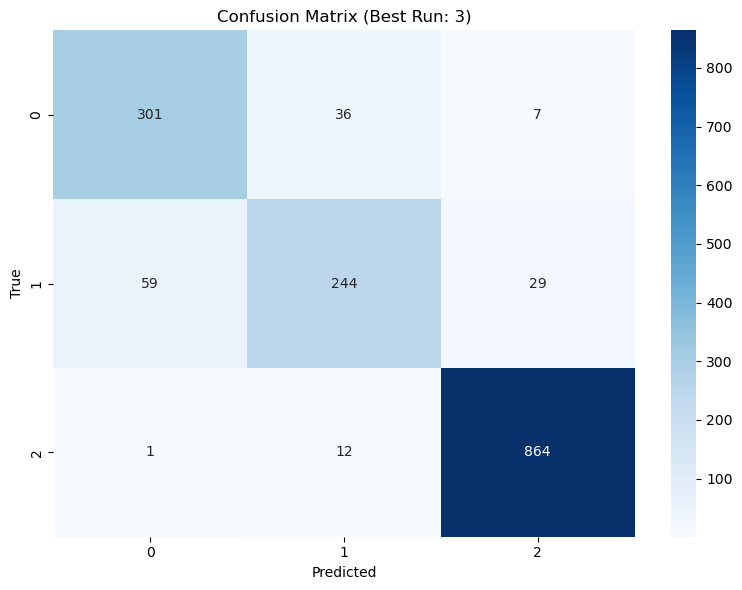

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.904057  0.862188    0.839949    0.769497    0.977117
1     0.883451  0.834608    0.847059    0.700000    0.956766
2     0.907276  0.869459    0.853901    0.782051    0.972425
3     0.894398  0.849944    0.840816    0.743151    0.965865
4     0.895042  0.847427    0.833555    0.735751    0.972973
Mean  0.896845  0.852725    0.843056    0.746090    0.969029
Std   0.008360  0.012113    0.006907    0.028569    0.007112

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.943833,0.882807,0.205995,0.355279
1,0.946216,0.878300,0.195221,0.414357
2,0.953024,0.900837,0.170373,0.308919
3,0.953932,0.888603,0.176704,0.375142
4,0.952116,0.889891,0.173807,0.389535
Mean,0.949824,0.888088,0.184420,0.368646
Std,0.004032,0.007612,0.013796,0.035536


In [15]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [16]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.782657  0.915698  0.843056   344.000000  0.031854  0.032043   
1             0.864969  0.657831  0.746090   332.000000  0.025521  0.052196   
2             0.958476  0.979932  0.969029   877.000000  0.014592  0.006727   
accuracy      0.896845  0.896845  0.896845     0.896845  0.009347  0.009347   
macro avg     0.868701  0.851154  0.852725  1553.000000  0.009002  0.013546   
weighted avg  0.899541  0.896845  0.893465  1553.000000  0.010404  0.009347   

                                  
              f1-score   support  
0             0.007723  0.000000  
1             0.031941  0.000000  
2             0.007951  0.000000  
accuracy      0.009347  0.009347  
macro avg     0.013543  0.000000  
weighted avg  0.011051  0.000000

## BiLSTM


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 1 - Accuracy: 0.9060, Macro F1: 0.8676, F1 Class 0: 0.8532, F1 Class 1: 0.7789, F1 Class 2: 0.9708

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 2 - Accuracy: 0.8944, Macro F1: 0.8504, F1 Class 0: 0.8447, F1 Class 1: 0.7411, F1 Class 2: 0.9654

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 3 - Accuracy: 0.8970, Macro F1: 0.8593, F1 Class 0: 0.8619, F1 Class 1: 0.7570, F1 Class 2: 0.9589

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 4 - Accuracy: 0.8950, Macro F1: 0.8536, F1 Class 0: 0.8518, F1 Class 1: 0.7458, F1 Class 2: 0.9632

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 5 - Accuracy: 0.9079, Macro F1: 0.8699, F1 Class 0: 0.8571, F1 Class 1: 0.7781, F1 Class 2: 0.9743


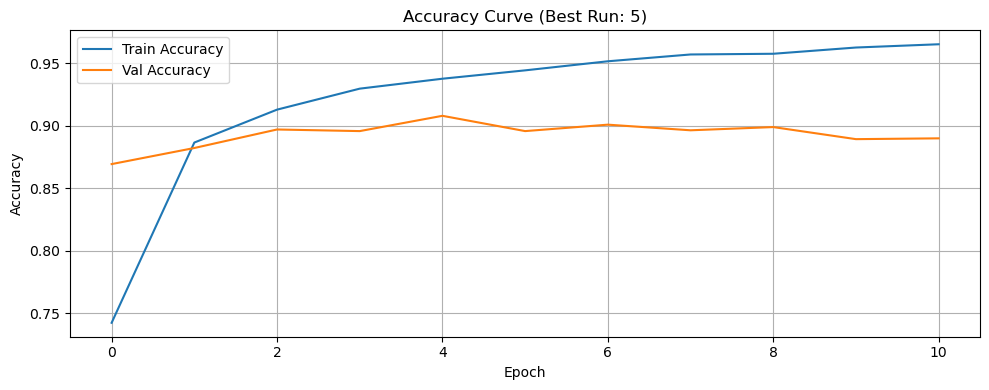

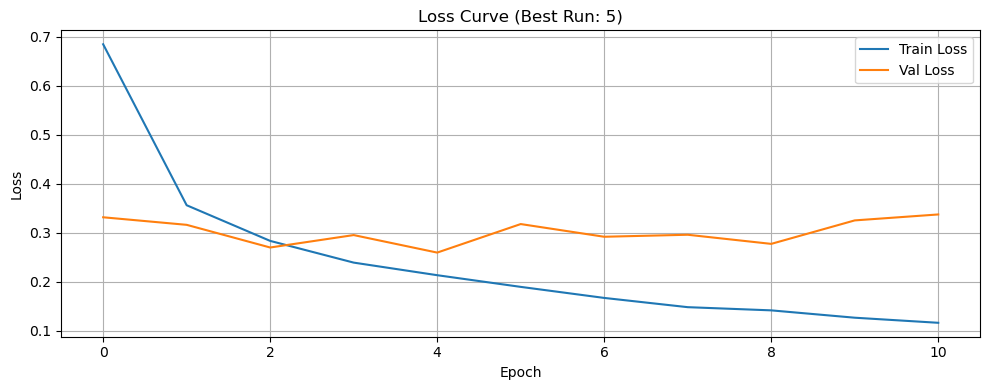


== Confusion Matrix of Best Run (Run 5) ==



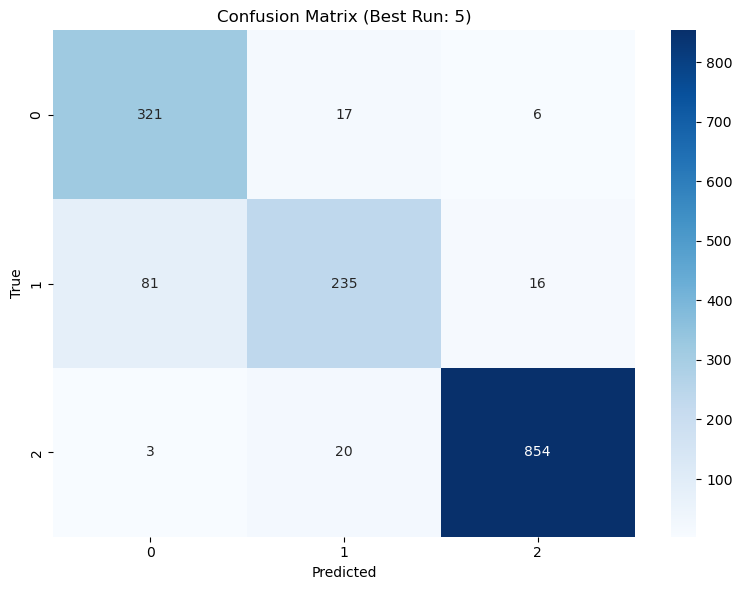

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.905988  0.867606    0.853186    0.778878    0.970754
1     0.894398  0.850402    0.844673    0.741135    0.965400
2     0.896974  0.859274    0.861878    0.757025    0.958920
3     0.895042  0.853593    0.851802    0.745763    0.963214
4     0.907920  0.869873    0.857143    0.778146    0.974330
Mean  0.900064  0.860150    0.853736    0.760189    0.966523
Std   0.005722  0.007601    0.005729    0.015830    0.005456

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.970498,0.880232,0.099127,0.299084
1,0.957903,0.882807,0.139455,0.317614
2,0.963009,0.883451,0.123180,0.327895
3,0.964938,0.884095,0.115127,0.304724
4,0.965165,0.889891,0.116011,0.337104
Mean,0.964303,0.884095,0.118580,0.317284
Std,0.004054,0.003181,0.013068,0.014103


In [21]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []  
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [22]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.794487  0.923837  0.853736   344.000000  0.025621  0.023741   
1             0.863538  0.680120  0.760189   332.000000  0.023054  0.034170   
2             0.959211  0.974002  0.966523   877.000000  0.010196  0.005781   
accuracy      0.900064  0.900064  0.900064     0.900064  0.006397  0.006397   
macro avg     0.872412  0.859320  0.860150  1553.000000  0.005333  0.008130   
weighted avg  0.902270  0.900064  0.897430  1553.000000  0.006244  0.006397   

                                  
              f1-score   support  
0             0.006405  0.000000  
1             0.017698  0.000000  
2             0.006100  0.000000  
accuracy      0.006397  0.006397  
macro avg     0.008498  0.000000  
weighted avg  0.007147  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 1 - Accuracy: 0.8983, Macro F1: 0.8537, F1 Class 0: 0.8368, F1 Class 1: 0.7536, F1 Class 2: 0.9707

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 2 - Accuracy: 0.8912, Macro F1: 0.8460, F1 Class 0: 0.8407, F1 Class 1: 0.7328, F1 Class 2: 0.9647

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Run 3 - Accuracy: 0.9073, Macro F1: 0.8671, F1 Class 0: 0.8522, F1 Class 1: 0.7757, F1 Class 2: 0.9735

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 4 - Accuracy: 0.9015, Macro F1: 0.8654, F1 Class 0: 0.8750, F1 Class 1: 0.7607, F1 Class 2: 0.9606

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Run 5 - Accuracy: 0.8944, Macro F1: 0.8498, F1 Class 0: 0.8544, F1 Class 1: 0.7314, F1 Class 2: 0.9636


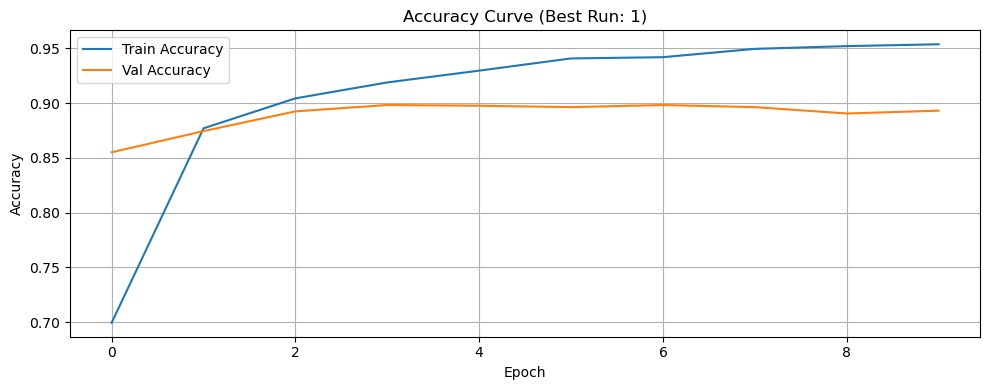

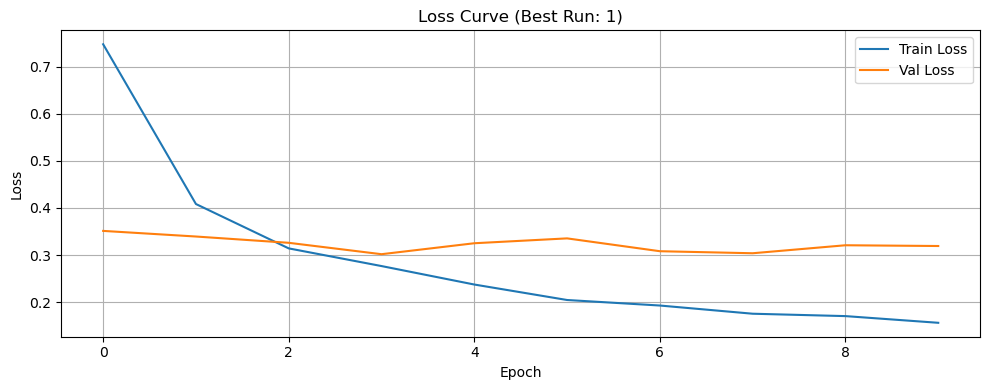


== Confusion Matrix of Best Run (Run 1) ==



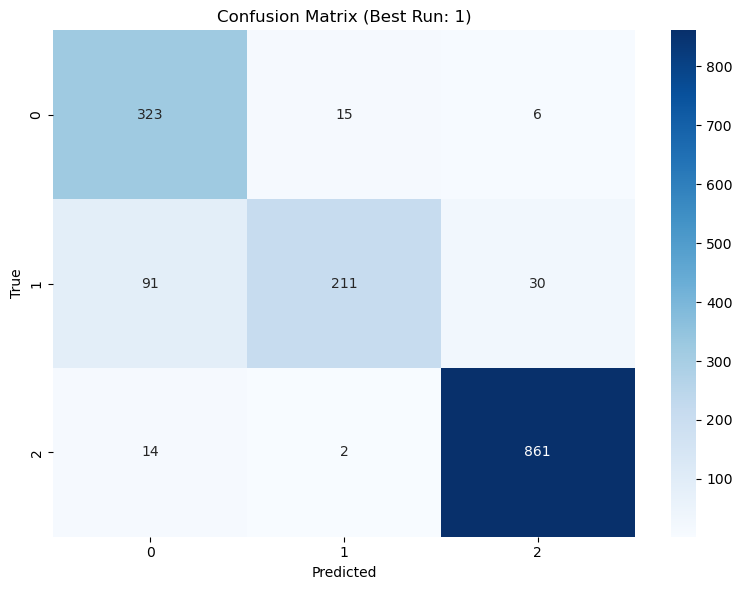

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.898261  0.853682    0.836788    0.753571    0.970688
1     0.891178  0.846033    0.840659    0.732773    0.964666
2     0.907276  0.867129    0.852243    0.775652    0.973491
3     0.901481  0.865414    0.875000    0.760656    0.960586
4     0.894398  0.849814    0.854447    0.731369    0.963626
Mean  0.898519  0.856414    0.851827    0.750804    0.966611
Std   0.005593  0.008421    0.013379    0.016882    0.004753

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.953705,0.893110,0.156165,0.319159
1,0.959719,0.875724,0.131747,0.389393
2,0.955520,0.893110,0.151638,0.287938
3,0.966073,0.890534,0.116057,0.341620
4,0.951662,0.877656,0.172422,0.394218
Mean,0.957336,0.886027,0.145606,0.346466
Std,0.005112,0.007705,0.019658,0.040787


In [23]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = []
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [24]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.793198  0.920930  0.851827   344.000000  0.030265  0.020390   
1             0.873558  0.659639  0.750804   332.000000  0.045578  0.026687   
2             0.953450  0.980160  0.966611   877.000000  0.007550  0.004387   
accuracy      0.898519  0.898519  0.898519     0.898519  0.006253  0.006253   
macro avg     0.873402  0.853576  0.856414  1553.000000  0.011020  0.009864   
weighted avg  0.900874  0.898519  0.895051  1553.000000  0.009279  0.006253   

                                  
              f1-score   support  
0             0.014958  0.000000  
1             0.018874  0.000000  
2             0.005314  0.000000  
accuracy      0.006253  0.006253  
macro avg     0.009415  0.000000  
weighted avg  0.006783  0.000000


================ Run 1 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 1 - Accuracy: 0.9008, Macro F1: 0.8632, F1 Class 0: 0.8625, F1 Class 1: 0.7619, F1 Class 2: 0.9652

================ Run 2 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 2 - Accuracy: 0.9073, Macro F1: 0.8673, F1 Class 0: 0.8420, F1 Class 1: 0.7832, F1 Class 2: 0.9769

================ Run 3 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 3 - Accuracy: 0.8886, Macro F1: 0.8353, F1 Class 0: 0.8395, F1 Class 1: 0.6987, F1 Class 2: 0.9675

================ Run 4 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 4 - Accuracy: 0.9041, Macro F1: 0.8636, F1 Class 0: 0.8575, F1 Class 1: 0.7611, F1 Class 2: 0.9721

================ Run 5 ================

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Run 5 - Accuracy: 0.8989, Macro F1: 0.8553, F1 Class 0: 0.8485, F1 Class 1: 0.7471, F1 Class 2: 0.9703


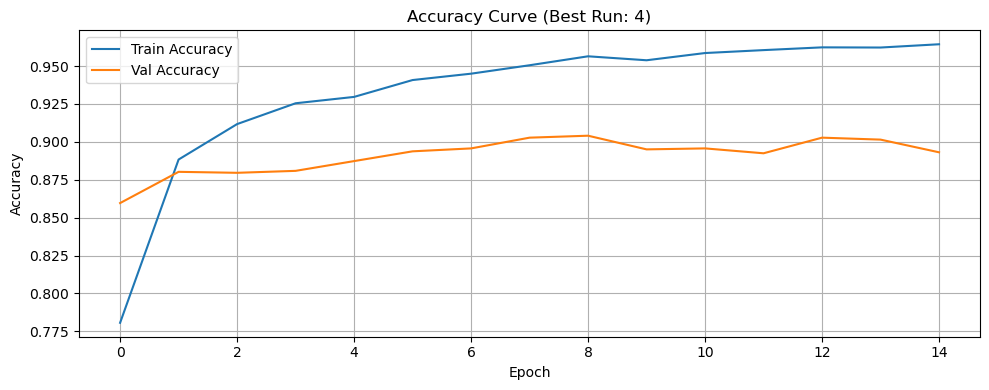

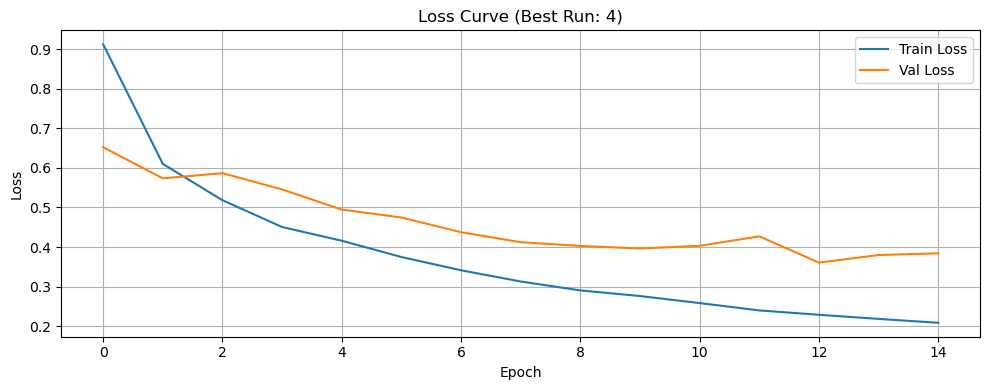


== Confusion Matrix of Best Run (Run 4) ==



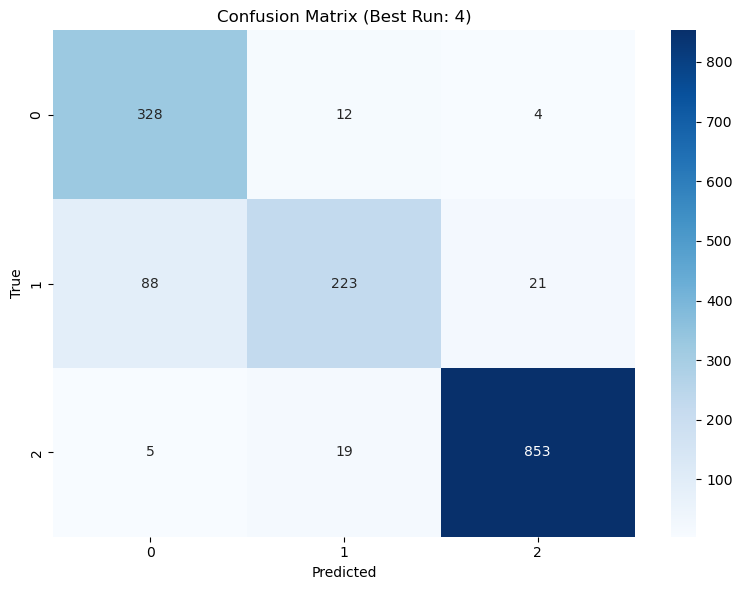

== Basic Metrics ==
      Accuracy  Macro F1  F1 Class 0  F1 Class 1  F1 Class 2
0     0.900837  0.863227    0.862534    0.761905    0.965242
1     0.907276  0.867335    0.841958    0.783172    0.976875
2     0.888603  0.835256    0.839538    0.698706    0.967525
3     0.904057  0.863563    0.857516    0.761092    0.972080
4     0.898905  0.855276    0.848485    0.747069    0.970275
Mean  0.899936  0.856931    0.850006    0.750389    0.970399
Std   0.006343  0.011527    0.008832    0.028298    0.003991

== Class-wise Report Summary ==

== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==


,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.960172,0.888603,0.228522,0.380927
1,0.976512,0.891822,0.142420,0.363677
2,0.958017,0.875080,0.232796,0.475850
3,0.964371,0.893110,0.208607,0.384127
4,0.968115,0.889891,0.180694,0.473993
Mean,0.965437,0.887701,0.198608,0.415715
Std,0.006538,0.006498,0.033591,0.048844


In [19]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, return_sequences=False,
                       dropout=0.3, recurrent_dropout=0.2,
                       kernel_regularizer=l2(0.001)))(inputs)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

reports = [] 
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

def run_multiple_trials(df, all_feature_cols, train_users, test_users, n_runs=5):
    acc_list, f1_macro_list, f1_class0_list, f1_class1_list, f1_class2_list = [], [], [], [], []

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    reports = []
    histories = []
    best_val_acc = -1
    best_conf_matrix = None
    best_run_index = -1

    for run in range(n_runs):
        print(f"\n================ Run {run+1} ================\n")
        tf.keras.backend.clear_session()
        np.random.seed(run)
        tf.random.set_seed(run)

        X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes = prepare_data(
            df, all_feature_cols,
            train_users=train_users,
            test_users=test_users
        )

        model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)

        early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=0)
        checkpoint = ModelCheckpoint(f'best_lstm_model_run{run+1}.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-5)

        history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint, reduce_lr],
        shuffle=False,
        verbose=0
        )

        histories.append(history.history)
        
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val_cat, axis=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_conf_matrix = confusion_matrix(y_true, y_pred)
            best_run_index = run + 1

        report_dict = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report_dict).T
        df_report["run"] = run + 1
        reports.append(df_report)

        acc = report_dict["accuracy"]
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_class0 = report_dict["0"]["f1-score"]
        f1_class1 = report_dict["1"]["f1-score"]
        f1_class2 = report_dict["2"]["f1-score"]

        acc_list.append(acc)
        f1_macro_list.append(f1_macro)
        f1_class0_list.append(f1_class0)
        f1_class1_list.append(f1_class1)
        f1_class2_list.append(f1_class2)
        
        print(f"Run {run+1} - Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}, F1 Class 0: {f1_class0:.4f}, F1 Class 1: {f1_class1:.4f}, F1 Class 2: {f1_class2:.4f}")
       
    perf_df = pd.DataFrame({
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train Loss': train_losses,
    'Val Loss': val_losses
    })
    perf_df.loc['Mean'] = perf_df.mean()
    perf_df.loc['Std'] = perf_df.std()

    result_df = pd.DataFrame({
        'Accuracy': acc_list,
        'Macro F1': f1_macro_list,
        'F1 Class 0': f1_class0_list,
        'F1 Class 1': f1_class1_list,
        'F1 Class 2': f1_class2_list,
    })
    result_df.loc['Mean'] = result_df.mean()
    result_df.loc['Std'] = result_df.std()

    full_report = pd.concat(reports)
    report_mean = full_report.drop(columns="run").groupby(level=0).mean()
    report_std = full_report.drop(columns="run").groupby(level=0).std()
    report_summary = pd.concat([report_mean, report_std], axis=1, keys=["Mean", "Std"])

    plot_best_run_learning_curve(histories, val_accuracies)

    print(f"\n== Confusion Matrix of Best Run (Run {best_run_index}) ==\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Best Run: {best_run_index})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return result_df, report_summary, perf_df, best_run_index
    
def plot_best_run_learning_curve(histories, val_accuracies):
    best_run = val_accuracies.index(max(val_accuracies))
    best_history = histories[best_run]

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['accuracy'], label='Train Accuracy')
    plt.plot(best_history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(best_history['loss'], label='Train Loss')
    plt.plot(best_history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve (Best Run: {best_run + 1})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_users = ['user1', 'user3', 'user4', 'user5', 'user6', 'user7']
test_users = ['user2', 'user8']

result_df, report_summary, perf_df, best_run_index = run_multiple_trials(
    df, all_feature_cols,
    train_users=train_users,
    test_users=test_users,
    n_runs=5
)

print("== Basic Metrics ==")
print(result_df)

print("\n== Class-wise Report Summary ==")
report_summary

print("\n== Final Epoch Train/Val Accuracy & Loss (Mean ± Std) ==")
perf_df

In [20]:
report_summary

Mean                                        Std            \
             precision    recall  f1-score      support precision    recall   
0             0.790489  0.920930  0.850006   344.000000  0.024995  0.034604   
1             0.861493  0.668072  0.750389   332.000000  0.028775  0.060068   
2             0.961596  0.979475  0.970399   877.000000  0.008697  0.009709   
accuracy      0.899936  0.899936  0.899936     0.899936  0.007092  0.007092   
macro avg     0.871193  0.856159  0.856931  1553.000000  0.003939  0.013262   
weighted avg  0.902294  0.899936  0.896698  1553.000000  0.005356  0.007092   

                                  
              f1-score   support  
0             0.009874  0.000000  
1             0.031639  0.000000  
2             0.004462  0.000000  
accuracy      0.007092  0.007092  
macro avg     0.012888  0.000000  
weighted avg  0.009142  0.000000